Mean Reversion Trading Strategy

In [75]:
#Modules & Packages 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf 

from datetime import date
import pandas_datareader.data as web
yf.pdr_override()
plt.style.use('fivethirtyeight')

In [76]:
#Data Collection Function 
def get_data(assets = assets_interest, start = start_date, end = end_date):
    data = web.get_data_yahoo(assets, data_source = 'yahoo', start = start, end = end)
    return data

In [77]:
#Here inside the brackets type the asset you would like to check
#Most cryptos are labeled as 'CRYPTO-USD' in yahoo, i.e XMR-USD, ETH-USD....
assets_interest = ['ETH-USD']


start_date = date(2018, 1, 1)
end_date = date.today()
print(end_date)

data = get_data(assets_interest)
data.to_csv('data.csv')
data.head(3)

2022-06-06
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-01,755.757019,782.530029,742.004028,772.640991,772.640991,2595760128
2018-01-02,772.346008,914.830017,772.346008,884.443970,884.443970,5783349760
2018-01-03,886.000000,974.471008,868.450989,962.719971,962.719971,5093159936


In [78]:
#Sinmple Moving Average Function 

def SMA(data, period = 30, column = 'Close'):
    return data[column].rolling(window = period).mean()

In [79]:
#Build and show the data set with the calculations needed to check the startegy

data['Simple M.A'] = SMA(data, 21)
data['Simple_Returns'] = data.pct_change(1)['Close']
data['Log_Returns'] = np.log(1 + data['Simple_Returns'])
data['Ratios'] = data['Close'] / data['Simple M.A']

#Let's check the dataset so far
data.tail()

,Open,High,Low,Close,Adj Close,Volume,Simple M.A,Simple_Returns,Log_Returns,Ratios
Date,,,,,,,,,,
2022-06-01,1942.050659,1965.166626,1776.053223,1823.569336,1823.569336,21037797760,1950.589152,-0.061142,-0.063092,0.934881
2022-06-02,1822.412109,1845.313965,1789.664185,1834.150513,1834.150513,17065041354,1944.515294,0.005802,0.005786,0.943243
2022-06-03,1834.135010,1840.058838,1746.509766,1775.078613,1775.078613,14878001811,1933.118170,-0.032207,-0.032737,0.918246
2022-06-04,1775.220825,1810.299683,1751.533325,1801.609497,1801.609497,8677951273,1920.991292,0.014946,0.014836,0.937854
2022-06-05,1801.818970,1825.859619,1777.133301,1805.204956,1805.204956,8850385937,1904.776919,0.001996,0.001994,0.947725


In [80]:
data['Ratios'].describe()

count    1597.000000
mean        1.007558
std         0.136714
min         0.498413
25%         0.925395
50%         0.999372
75%         1.089541
max         1.608538
Name: Ratios, dtype: float64

In [81]:
#Compute and show the percentile values

percentiles = [15, 20, 50, 80, 85]

#Remove NA values in the ratios columns and store results in a new variable
ratios = data['Ratios'].dropna()

#Get the values of the percentiles
percentile_values = np.percentile(ratios, percentiles)
percentile_values


array([0.88174164, 0.90478916, 0.99937172, 1.1130086 , 1.14682393])

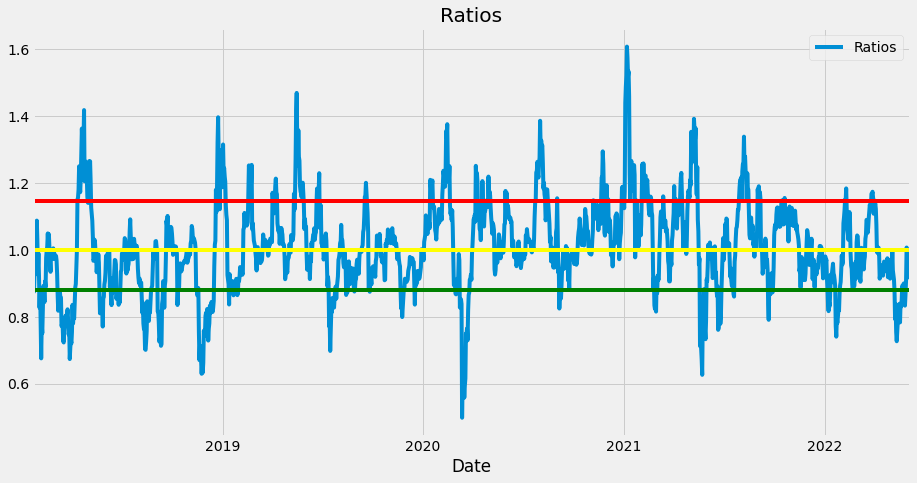

In [82]:
#Plot the ratios 
plt.figure(figsize=(14,7))
plt.title("Ratios")
data['Ratios'].dropna().plot(legend = True)
plt.axhline(percentile_values[0], c = 'green', label = '15th percentile')
plt.axhline(percentile_values[2], c = 'yellow', label = '50th percentile')
plt.axhline(percentile_values[-1], c = 'red', label = '85th percentile')

In [83]:
# Buy & Sell Signals for the strategy

sell = percentile_values[-1] #85th percentile threshold where we want to sell
buy = percentile_values[0] #15th percentile threshold where we want to buy 

#print -1 where the ratio is greater than the SELL percentile in order to SELL & nan otherwise
data['Positions'] = np.where(data.Ratios > sell, -1, np.nan)

#print 1 where the ratio is lower than the BUY percentile in order to BUY & Nan otherwise
data['Positions'] = np.where(data.Ratios < buy, 1, data['Positions'])

#Use ffill to fill missing values in our data dataframe

data['Positions'] = data['Positions'].ffill()

data['Buy'] = np.where(data.Positions == 1, data['Close'], np.nan)
data['Sell'] = np.where(data.Positions == -1 , data['Close'], np.nan)

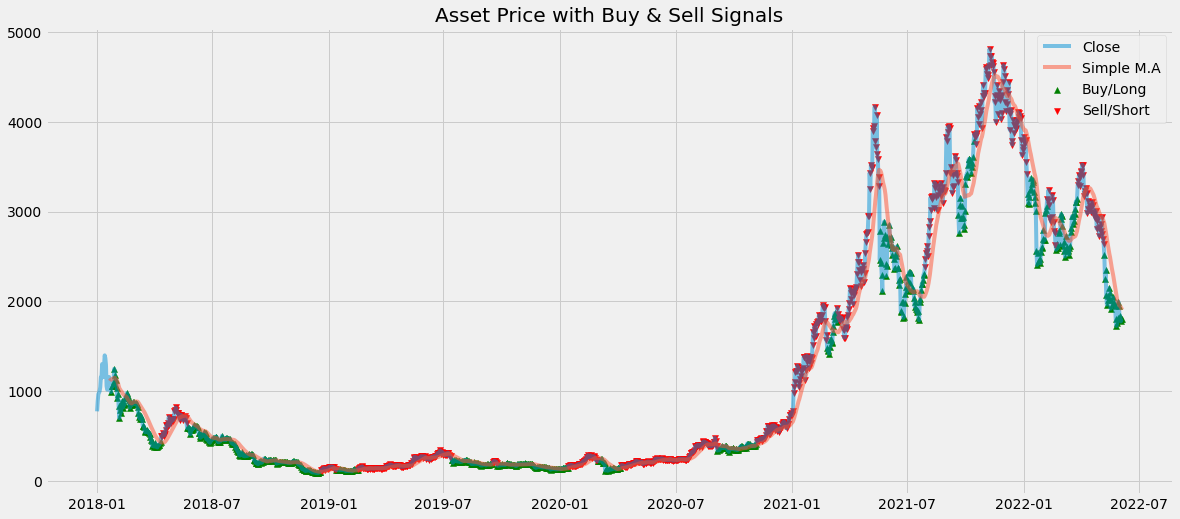

In [84]:
plt.figure(figsize=(18,8))
plt.title("Asset Price with Buy & Sell Signals")
plt.plot(data['Close'], alpha = 0.5, label = 'Close')
plt.plot(data['Simple M.A'], alpha = 0.5, label = 'Simple M.A')
plt.scatter(data.index, data['Buy'], color = 'green', label = 'Buy/Long', marker = '^', alpha = 1)
plt.scatter(data.index, data['Sell'], color = 'red', label = 'Sell/Short', marker = 'v', alpha = 1)
plt.legend()
plt.show()

Calculating the returns with the Mean Reversion Strategy

In [85]:
data['MeanStrategy_Returns'] = data.Positions.shift(1) * data.Log_Returns
data['MeanStrategy_Returns']

Date
2018-01-01         NaN
2018-01-02         NaN
2018-01-03         NaN
2018-01-04         NaN
2018-01-05         NaN
                ...   
2022-06-01   -0.063092
2022-06-02    0.005786
2022-06-03   -0.032737
2022-06-04    0.014836
2022-06-05    0.001994
Name: MeanStrategy_Returns, Length: 1617, dtype: float64

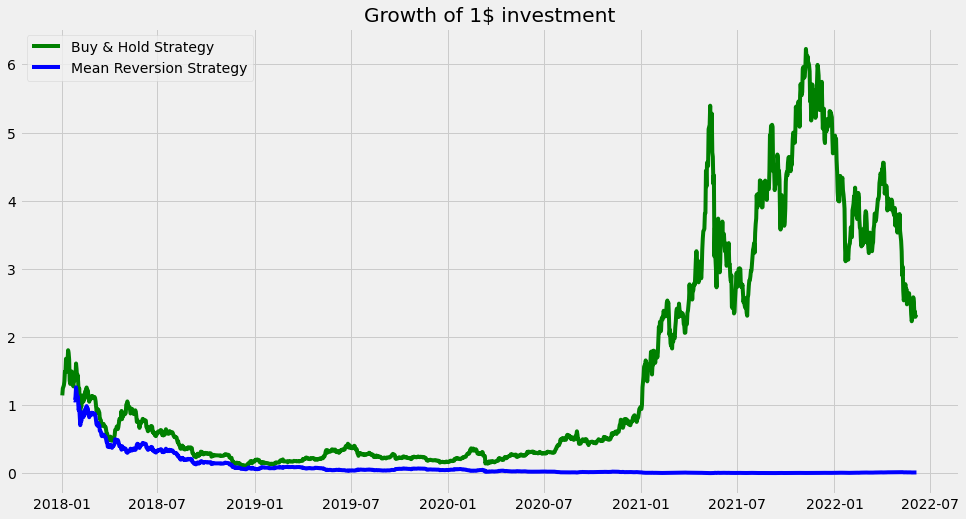

In [86]:
plt.figure(figsize=(15, 8))
plt.title("Growth of 1$ investment")
plt.plot(np.exp(data['Log_Returns'].dropna()).cumprod(), color = 'green', label = 'Buy & Hold Strategy')
plt.plot(np.exp(data['MeanStrategy_Returns'].dropna()).cumprod(), color = 'blue', label = 'Mean Reversion Strategy')
plt.legend()

In [87]:
#Print the returns of both strategies

print("Buy-n-Hold Strategy Returns:", np.exp(data['Log_Returns'].dropna()).cumprod()[-1] - 1)
print("Mean Reversion Strategy Returns:", np.exp(data['MeanStrategy_Returns'].dropna()).cumprod()[-1] - 1)

Buy-n-Hold Strategy Returns: 1.3364084698968055
Mean Reversion Strategy Returns: -0.9860679834995785


Best strategy for crypto assets seems to be the Buy & Hold strategy!